In [23]:
# Import Python 3 print function
from __future__ import print_function

# Import OGR - 
from osgeo import ogr


# Open the dataset from the file
dataset = ogr.Open('roi_upper_c.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')

### Let's get the driver from this file
driver = dataset.GetDriver()
print('Dataset driver is: {n}\n'.format(n=driver.name))

### How many layers are contained in this Shapefile?
layer_count = dataset.GetLayerCount()
print('The shapefile has {n} layer(s)\n'.format(n=layer_count))

### What is the name of the 1 layer?
layer = dataset.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))

### What is the layer's geometry? is it a point? a polyline? a polygon?
# First read in the geometry - but this is the enumerated type's value
geometry = layer.GetGeomType()

# So we need to translate it to the name of the enum
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: roi_upper_c

The layer's geometry is: Polygon

Layer projection is: +proj=longlat +datum=WGS84 +no_defs 

Layer has 20 features

Layer has 2 fields
Their names are: 
	id - Integer64
	name - String


In [24]:
# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open('upper-0043_nodata.tif', gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

print(ncol)
print(nrow)

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('training_data.gtif', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [0],  # burn value 0
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=id']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

446
388
Success


In [25]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open('training_data.gtif', gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 170882 pixels
Class 1 contains 1655 pixels
Class 2 contains 226 pixels
Class 3 contains 285 pixels


(388, 446, 4)


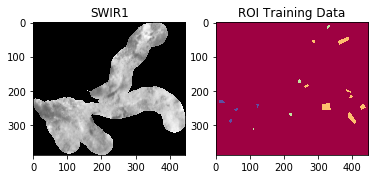

In [26]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('upper-0043_nodata.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

print(img.shape)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 3], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')
                                                                                                
plt.show()

In [27]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


We have 2166 samples
The training data include 3 classes: [1 2 3]
Our X matrix is sized: (2166, 4)
Our y array is sized: (2166,)


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [29]:
bands = [1, 2, 3, 4]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.19816694722659087
Band 2 importance: 0.20616988450940174
Band 3 importance: 0.20875157104365627
Band 4 importance: 0.3869115972203513


In [30]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print(new_shape)
img_as_array = img[:, :, :4].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

print('Finished')

(173048, 4)
Reshaped from (388, 446, 4) to (173048, 4)
Finished


(388, 446)
width: 446
height: 388
shape final img has (388, 446, 3) 

pixel 1 [0 0 0] features

type pixel 1 <class 'numpy.ndarray'> features



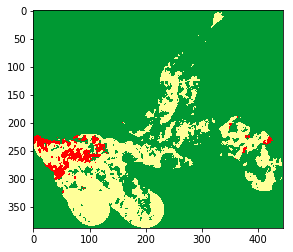

In [33]:
#plt.imshow(class_prediction)
#print(class_prediction.shape)
#plt.imshow(class_prediction[class_prediction == 6])
#plt.imshow(class_prediction, interpolation='lanczos')
#plt.show()
print(class_prediction.shape)
width = class_prediction.shape[1]
height = class_prediction.shape[0]
print("width:", width)
print("height:", height)
final_img = np.zeros([height, width, 3], dtype=np.uint8)
print('shape final img has {n} \n'.format(n=final_img.shape))
print('pixel 1 {n} features\n'.format(n=final_img[0][0]))
print('type pixel 1 {n} features\n'.format(n=type(final_img[0][0])))

#colors = {0: np.array([0,0,0]), 1: np.array([0,150,0]), 2: np.array([0,0,255]), 3: np.array([0,255,0]), 
#         4: np.array([160,82,45]), 5: np.array([255,0,0])}
colors = {0: np.array([255,255,255]), 1: np.array([0,153,51]), 2: np.array([255,255,153]), 3: np.array([255,0,0]), 
         4: np.array([255,255,255])}

for i in range(0, height):
    for j in range(0, width):
        final_img[i][j] = colors[class_prediction[i][j]]
plt.imshow(final_img)
plt.show()
#print(type(colors[1]))
#(1, (0, 150, 0, 255)),  # Forest
#(2, (0, 0, 255, 255)),  # Water
#(3, (0, 255, 0, 255)),  # Herbaceous
#(4, (160, 82, 45, 255)),  # Barren
#(5, (255, 0, 0, 255))  # Urban